<center><h1>How do Redditors Feel about Bitcoin?</h1></center>

We, team MAGA (Make Analysis Geert Again) obtained a dataset of information from `r/bitcoin` from time period {start} to {finish}. In this part of the assignment, our goal is to do the following:
- Visualize the contents of the thread text. Assess how content changes over time
- Determine the sentiment of the reddit threads; again, see how it changes over time
- Perform Topic Modeling to extract the topics of these threads
- Build a predictive model of the sentiment of the text
- Build a predictive model of the price of bitcoin given sentiment and trending topics in the text

### Data Preparation and Exploration

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pdtext
from pdtext.tf import word_count
import sklearn
import math

Below, we read in the dataset and examine the contents of the text. We find that 70% of the text is either removed, deleted or non-existent. We ultimately yield a reduced dataset.

In [124]:
# dataset
df = pd.read_csv("df_final.csv")

In [125]:
# for now, we need only the text. 
text = df['text']
len(text)
# note: a lot of the text are NaN or deleted.
text.head(10)
# let's see what percent of the data have NaN or [deleted] or [removed]

np.mean(text == '[deleted]') # 0.064179, ok 6% are deleted
np.mean(text == '[removed]') # 0.10819
text.isnull().mean() # 51.9%...ok

keep = (~text.isnull()) & (~(text == '[deleted]')) & (~(text == '[removed]'))

# make a copy of the original dataframe
df_og = df
# add the column "missing" to be an indicator of a missing text. We'll plot this to see how it's distributed 
# over time

df_og['missing'] = ~keep


# keep only the threads with actual text                           
df = df.loc[keep]
df.shape[0]/len(text) # 0.3085, so ultimately only 30% of the threads are usable for sentiment analysis
# for a future ML model, would be interesting to create features that describe whether the text is deleted, removed or empty
# question: why are so many of the threads null? is it due to the API, 
# or was the thread archived and thus the text is now null?

0.30851010140561724

First, let's check our text over time. Was there a specific time period where a lot of the text is missing? To do so, let's see the mean number of comments per day. If there is a date missing, it would show

<AxesSubplot:>

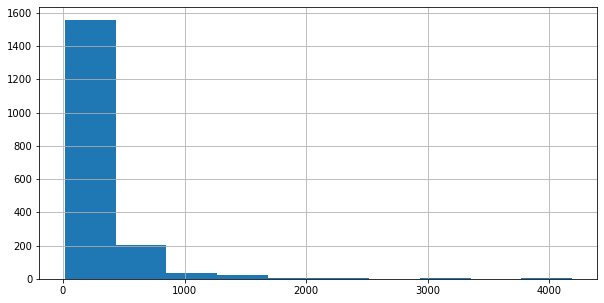

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

# Plot the number of threads in a day, and the number of missing threads in a day
# how to do it side-by-side?

df_og['Day'].value_counts().hist()
#df_og.groupby('Day').missing.sum().hist()

In [5]:
#%pip install calmap

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(<Figure size 1152x576 with 5 Axes>,
 array([<AxesSubplot:ylabel='2016'>, <AxesSubplot:ylabel='2017'>,
        <AxesSubplot:ylabel='2018'>, <AxesSubplot:ylabel='2019'>,
        <AxesSubplot:ylabel='2020'>], dtype=object))

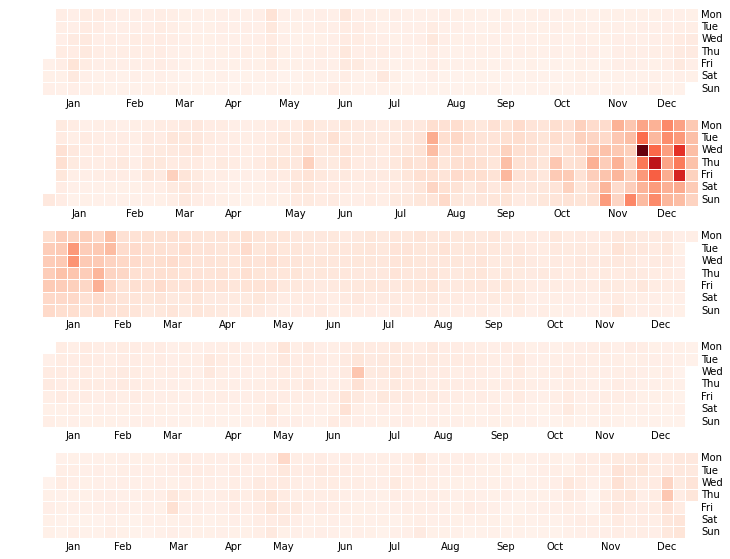

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
import calmap # example from: https://pythonhosted.org/calmap/
import datetime

# calendar heatmap: missing text by day
day = pd.to_datetime(df_og.groupby('Day').missing.sum().index)

# sum of missing text by day
missing_by_day = np.array(df_og.groupby('Day').missing.sum())

missing = pd.Series(missing_by_day, index=day)


calmap.calendarplot(missing, fillcolor='white')


It seems that the bulk of missing text occurs in November-December 2017. Beyond that, I don't see any trend in missingness.

#### Word Count and TF Matrix

In [126]:
# back to the reduced dataframe

df['word_count'] = df['text'].apply(word_count)

<ipython-input-126-68de2c13521c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['text'].apply(word_count)


In [8]:
df['word_count'].describe()

count    177277.000000
mean         86.942311
std         153.264900
min           0.000000
25%          23.000000
50%          49.000000
75%          95.000000
max        6831.000000
Name: word_count, dtype: float64

For now, I will do a cool visualization: look at the TF-IDF matrices for each year and see how things change.

In [127]:
def get_year(date):
    return(date[0:4])

year = pd.Series(df['Day'].apply(get_year))

df.loc[df.index,'year'] = year

/home/nkawa/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/nkawa/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [119]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# get the data from year 2016
df_2016 = df[df['year']=='2018']
#df_2016 = df    

In [120]:
from sklearn.feature_extraction import text

# add stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["https", "www", "com", "bitcoin", "btc", "bitcoins",
                                              "just","like", "wallet", "btc", "blockchain"])

tf = TfidfVectorizer(stop_words = my_stop_words,#stop_words='english', 
                     lowercase=True, 
                     analyzer='word', 
                     #token_pattern=u'(?u)\b\w*[a-zA-Z]\w*\b',
                     #min_df = 0.05,
                     use_idf = True)
tf_2016 = tf.fit_transform(df_2016['text'])


In [121]:
tf_2016_df = pd.DataFrame(tf_2016.T.todense(), 
                  index=tf.get_feature_names()) 

In [122]:
tf_2016_tot = pd.DataFrame(data = np.array(tf_2016_df.sum(axis=1)),
                           index = tf.get_feature_names(),
                          columns = ['tfidf_score'])

In [123]:
tf_2016_tot.sort_values(by='tfidf_score', ascending = False)[0:50]

,tfidf_score
price,464.097651
know,422.779493
crypto,417.761503
people,406.145957
buy,403.207866
amp,388.769171
money,377.800216
time,352.322525
don,347.364901
want,334.327312


### Feature Engineering
We can get features about the text to (1) analyze the text inself (2) feed it into a predictive model.

In [128]:
# A very, very simple model: Count the number of question marks. More quesiton marks --> higher 
# probability that it's a question

def count_q(txt):
    return(txt.count('?'))

#def count_excl(txt):
#    return(txt.count('!'))

df['n_qmarks'] = df['text'].apply(count_q)
#df['n_expl'] = df['text'].apply(count_excl)


<ipython-input-128-afeb8c018997>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_qmarks'] = df['text'].apply(count_q)


In [129]:
df['n_qmarks'].describe()

count    177277.000000
mean          1.082086
std           1.691914
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         155.000000
Name: n_qmarks, dtype: float64

In [130]:
df.keys()

Index(['id', 'timestamp', 'author', 'score', 'comments', 'title', 'text',
       'Time', 'Day', 'missing', 'word_count', 'year', 'n_qmarks'],
      dtype='object')

### Topic Modeling: Latent Dirichlet Allocation

In [146]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /home/nkawa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [159]:
# Data Cleaning: First, we need to clean the data to improve the accuracy

# NOTE: for now I won't stem: too much time. And I don't see that it will necessarily help

from nltk.stem.snowball import SnowballStemmer 
eng_stemmer = SnowballStemmer("english")

def stem_sentence(sentence):
    new_sentence = ''
    for word in word_tokenize(sentence):
        new_sentence = new_sentence + ' ' + eng_stemmer.stem(word)
    return new_sentence.strip()

In [155]:
print(eng_stemmer.stem('cryptocurrency'))
print(eng_stemmer.stem('crypto'))

print(eng_stemmer.stem('mining'))
print(eng_stemmer.stem('mine'))

print(stem_sentence(df['text'].iloc[420]))

cryptocurr
crypto
mine
mine
two part question : 1 ) the github platform , do user need permiss to add to a discuss like that , general on all repositori ? 2 ) can repositori owner delet comment or otherwis allow or block user from comment on repositori they otherwis do not contribut to ?


In [175]:
df['stemmed_text'] = df['text'].apply(stem_sentence)

<ipython-input-175-70ba2fc8b445>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed_text'] = df['text'].apply(stem_sentence)


In [186]:
# remove punctuation and numbers
import string

# remove numbers and punctuation
def clean_text(s):  
    # remove numbers: https://stackoverflow.com/questions/12851791/removing-numbers-from-string
    s = ''.join([i for i in s if not i.isdigit()])
    # remove punctuation: 
    s = s.translate(str.maketrans('', '', string.punctuation))
    return(s)

df['stemmed_text'] = df['stemmed_text'].apply(clean_text)

<ipython-input-186-8d97fce8283f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed_text'] = df['stemmed_text'].apply(clean_text)


In [191]:
df['stemmed_text'].iloc[420]

'two part question    the github platform  do user need permiss to add to a discuss like that  general on all repositori    can repositori owner delet comment or otherwis allow or block user from comment on repositori they otherwis do not contribut to'

In [194]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text

In [217]:
# add stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["https", "www", "com", "bitcoin", "btc", "bitcoins",
                                              "just","like", "wallet", "btc", "blockchain",
                                              "amp", "ve"])


vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,1),
                             max_df      = .3,
                             stop_words  = my_stop_words,
                             min_df      = .05,
                             max_features = None)

In [218]:
vectorizer.fit(df['stemmed_text'])

CountVectorizer(max_df=0.3, min_df=0.05,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'amp', 'an', 'and', 'another', 'any',
                                      'anyhow', 'anyone', 'anything', 'anyway', ...}))

In [219]:
len(vectorizer.get_feature_names())

85

In [220]:
vectorizer.get_feature_names()

['account',
 'address',
 'ani',
 'anyon',
 'ask',
 'bank',
 'becaus',
 'befor',
 'best',
 'block',
 'buy',
 'coin',
 'coinbas',
 'come',
 'creat',
 'crypto',
 'currenc',
 'current',
 'day',
 'did',
 'differ',
 'doe',
 'everi',
 'exchang',
 'fee',
 'futur',
 'good',
 'got',
 'guy',
 'happen',
 'help',
 'invest',
 'know',
 'let',
 'long',
 'look',
 'lot',
 'make',
 'mani',
 'market',
 'mean',
 'money',
 'month',
 'need',
 'network',
 'new',
 'nt',
 'onli',
 'pay',
 'peopl',
 'pleas',
 'possibl',
 'post',
 'price',
 'question',
 'read',
 'realli',
 'right',
 'say',
 'sell',
 'send',
 'sinc',
 'someon',
 'someth',
 'start',
 'support',
 'sure',
 'thank',
 'thing',
 'think',
 'thought',
 'time',
 'trade',
 'transact',
 'transfer',
 'tri',
 'understand',
 'use',
 'valu',
 'veri',
 'want',
 'way',
 'whi',
 'work',
 'year']

In [221]:
review_tf = vectorizer.transform(df['text'])

In [222]:
lda_model = LatentDirichletAllocation(n_components   = 10,
                                      max_iter       = 50,
                                      evaluate_every = 5,
                                      verbose = 1)

In [223]:
lda_model.fit(review_tf)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50, perplexity: 58.2016
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50, perplexity: 56.8379
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50, perplexity: 56.3179
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50, perplexity: 56.1192
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50, perplexity: 55.9723
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50, per

LatentDirichletAllocation(evaluate_every=5, max_iter=50, verbose=1)

In [224]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(review_tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(review_tf))

Log Likelihood:  -3456903.192273178
Perplexity:  55.35565871837389


In [225]:
lda_model.transform(review_tf)


array([[0.03333334, 0.03333554, 0.03333339, ..., 0.03333565, 0.03333474,
        0.03333532],
       [0.01428571, 0.15714286, 0.01428571, ..., 0.44285607, 0.01428571,
        0.01428621],
       [0.025     , 0.025     , 0.025     , ..., 0.0250101 , 0.025     ,
        0.3835585 ],
       ...,
       [0.02      , 0.02      , 0.22      , ..., 0.02      , 0.02      ,
        0.02      ],
       [0.42112808, 0.21885849, 0.02      , ..., 0.02      , 0.02      ,
        0.02      ],
       [0.02500109, 0.025     , 0.02500005, ..., 0.02501303, 0.02500565,
        0.27498291]])

In [226]:
def column_swap(column):
    column = column.sort_values(ascending = False)
    return column.index

def topic_words_df(lda_model, vectorizer):
    '''
    Generate dataframe of words associated with a topic model.
    '''
    
    word_topic_scores = lda_model.components_.T
    vocabulary        = vectorizer.get_feature_names()
    
    
    topic_words_df = pd.DataFrame(word_topic_scores,
                                  index = vocabulary)
    
    topic_words_df = topic_words_df.apply(column_swap).reset_index(drop = True).rename_axis('rank')
    
    topic_words_df.index = topic_words_df.index + 1
    
    return topic_words_df

In [228]:
topic_words_df(lda_model, vectorizer).sample(30)

,0,1,2,3,4,5,6,7,8,9
rank,,,,,,,,,,
26,look,mani,lot,tri,know,say,best,want,let,make
45,read,good,right,good,price,guy,mean,current,help,pay
4,trade,transfer,block,work,did,thank,say,time,got,year
84,realli,onli,realli,realli,sinc,everi,everi,sinc,possibl,onli
52,question,think,guy,invest,sell,mean,thought,sell,money,coin
65,thank,support,mani,send,coinbas,sell,send,bank,coin,send
59,ani,nt,price,coin,question,price,coin,network,best,crypto
72,whi,tri,valu,whi,address,doe,creat,valu,valu,whi
77,veri,anyon,ani,currenc,currenc,veri,befor,ani,befor,befor
